# Import section

In [1]:
from stage2 import *
import numpy as np
from astropy.io.votable import parse
import matplotlib.lines as mlines

# Creating a general class to gather group information into one object

In [2]:
class groupStructure:
    
    def __init__(self, groupName, listGals, redshifts, lsf, 
                 wavelengthOfObservation=3729, PA=0, inclination=-30, 
                 XcenPos=15.0, YcenPos=15.0, RA=None, DEC=None,
                 lmass=None, lmassLE=None, lmassUE=None,
                 lsfr=None, lsfrLE=None, lsfrUE=None, mag=None, 
                 kinematicalPA=None, dkinematicalPA=None,
                 halfLightSize=None,
                 Rplateau=None, dRplateau=None,
                 Rlast=None,
                 sigmaV=None, 
                 Vplateau=None, dVplateau=None,
                 chi2=None):
        '''
        Intialisation of the group structure. Parameters should be given with the right units. See mandatory and optional inputs for more information.
        
        Mandatory inputs
        ----------------
        groupName : string
            the name of the group
        listGals : list of strings
            the path to the gals folders
        lsf : list of floats
            the line spread function FWHM of the galaxies in km/s    
        redshifts : list of floats
            the redshifts of the galaxies
            
        Optional inputs
        ---------------
        chi2 : list of floats
            chi2 of the minimisation algorithm
        DEC : list of floats
            declination of the galaxy centre (degrees only)
        dkinematicalPA : list of floats
            error on kinematicalPA
        dRplateau : list of floats
            error on the plateau radius
        dVplateau : list of floats
            error on Vplateau
        halfLightSize : list of floats
            half light radius of the galaxies in pixel
        inclination : list of floats
            inclination of the galaxies on the sky (between 0° and +90°)
        kinematicalPA : list of floats
            kinematical PA as returned from a kinematical model
        lmass : list of floats
            log10 of the mass of the galaxies in solar masses
        lmassLE : list of floats
            lower error (1 sigma) on the log10 of the mass
        lmassUE : list of floats
            upper error (1 sigma) on the log10 of the mass
        lsfr : list of floats
            log10 of the SFR of the galaxies in solar masses per year
        lsfrLE : list of floats
            lower error (1 sigma) on the log10 of the sfr
        lsfrUE : list of floats
            upper error (1 sigma) on the log10 of the sfr
        mag : list of floats
            magnitude (apparent or absolute)of the galaxies
        PA : list of floats
            morphological position angle of the galaxies (between -90° and +90°)
        RA : list of floats
            right ascension of the galaxy centre (degrees only)
        Rlast : list of floats
            most distant radius where the kinematical fit was performed
        Rplateau : list of floats
            plateau radius in pixel
        sigmaV : list of floats
            velocity dispersion
        Vplateau : list of floats
            plateau velocity for a ramp model
        wavelengthOfObservation : list of integers/floats
            wavelength at which we observed the galaxies (default is OII, must be given in Angstroms)
        XcenPos : list of floats
            X position in pixel of the centre in a MUSE image of 30x30px
        YcenPos : list of floats
            Y position in pixel of centre in a MUSE image of 30x30px
        
            
        Attributes
        ----------
            
            Attributes units
            ----------------
            To each attribute corresponds a unit marked with two _ before the attribute name.
            Some of these are used to convert values from one unit to another or to print them in a certain format. Do not change them directly but use the relevant functions.
            Avaiblable units are
                angles     : deg, rad, arcmin, arcsec, hours, minutes, seconds
                length     : px (MUSE pixel of size 0.2")
                wavelength : angstrom, nm
                
        __hstGroup : str
            an identifier for the group to find hst images
        __ln : int
            number of galaxies associated to the object. It is computed at the creation of the object and should not be changed after.
        dec : list of floats
            declination (degrees only) of each galaxy
        discSlen : list of floats
            disc scale length of the galaxies
        dkin_PA : list of floats
            error on kin_PA
        dRp : list of floats
            error on the plateau radius
        dVmax : list of floats
            error on Vmax
        dVp : list of floats
            error on Vplateau
        group : str
            group name
        galsFolder : str
            the group folder where the galaxies folders are stored
        galsNames : list of str
            name of the galaxies
        galsNum : list of int
            number associated to each galaxy
        hstFolder : str
            group folder where the hst images of the galaxies are stored
        inclination : list of int
            inclination of the galaxies on the sky. 
        kin_PA : list of floats
            kinematical position angle of each galaxy (between -90° and +90°). Default is 0°.
        lmass : list of floats
            log10 of the mass in solar masses
        lmassLE : list of floats
            lower error on lmass
        lmassUE : list of floats
            upper error on lmass
        lsf : list of floats
            line spread function of each galaxy
        lsfr : list of floats
            log10 of the SFR of the galaxies
        lsfr_le : list of floats
            lower error (1 sigma) on the log10 of the sfr
        lsfr_ue : list of floats
            upper error (1 sigma) on the log10 of the sfr
        mag : list of floats
            apparent or absolute magnitude of the galaxies
        PA : list of floats
            morphological position angle of each galaxy (between -90° and +90°). If no value or a None is given, default will be put to -30°.
        psf : list of floats
            psf at the redshift of every galaxy in pixel. This requires to know the redshift beforehand.
        ra : list of floats
            right ascension (degrees only) of each galaxy
        R1_2 : list of floats
            half light radius of galaxies in pixel
        Rd : list of floats
            disc scale length
        Rlast : list of floats
            most distant radius where the kinematical fit was performed
        Rmax : list of floats
            position where the maximum velocity is computed (taken as 2.2*Rd)
        Rp : list of floats
            plateau radius in pixel
        sigV : list of floats
            velocity dispersion
        Vmax : list of floats
            maximum velocity computed at Rmax
        Vp : list of floats
            plateau velocity for a ramp model
        wv : list of floats
            wavelength of observation (redshifted) in Angstrom of the galaxies. This requires to know the redshift beforehand.
        XcenPos : list of floats
            X position in pixel of the centre in a MUSE image of 30x30px of every galaxy
        YcenPos : list of floats
            Y position in pixel of centre in a MUSE image of 30x30px of every galaxy
        z : list of floats
            resdhift of each galaxy
        '''
        
        def transformToList(data, lngth):
            try:
                len(data)
            except TypeError:
                data            = [data]*lngth
            return [np.nan if d is None else d for d in data]
            

        ### Filling lists of mandatory fields ###
        
        #galaxies folders and names
        self.__ln               = len(listGals)
        self.group              = groupName
        self.__hstGroup         = self.group if self.group == "84-N" else  self.group.split('_')[0].split('-')[0]
        self.galsNames          = [gal.split("o2/")[1] for gal in listGals]
        self.galsFolder         = listGals[0].split("o2")[0]
        self.galsNum            = [int(gal.split("_")[-2]) for gal in self.galsNames]
        self.hstFolder          = ["/home/wilfried/ST2/data/hst/CGr" + self.__hstGroup + "/" + str(gnum) + "_CGr" + self.__hstGroup + ".fits" for gnum in self.galsNum]
        
        #redshift
        self.z                  = [z for z in redshifts]
        
        #lsf FWHM
        self.lsf                = [l for l in lsf]
        self.__lsf_unit         = "km/s"
        
        ### Filling lists of optional fields ###
        ## morphological information ##
        
        #centre position
        self.XcenPos            = transformToList(XcenPos, self.__ln)
        self.__XcenPos_unit     = "px"
        self.YcenPos            = transformToList(YcenPos, self.__ln)
        self.__YcenPos_unit     = "px"
        self.ra                 = transformToList(RA, self.__ln)
        self.__ra_unit          = "deg"
        self.dec                = transformToList(DEC, self.__ln)
        self.__dec_unit         = "deg"

        #define default wavelength of observation for this group (OII at the group redshift in Angstrom)
        self.wv                 = transformToList(wavelengthOfObservation, self.__ln)
        self.wv                 = [wv*(1+z) for wv, z in zip(self.wv, self.z)]
        self.__wv_unit          = "angstrom"
        
        #generate PSF FWHM for each galaxy
        self.psf                = computeGroupFWHM(self.wv, [self.group]*self.__ln, verbose=False, model='Gaussian')
        self.__psf_unit         = "px"
        
        #set default morphological PA
        self.PA                 = transformToList(PA, self.__ln)
        self.__PA_unit          = "deg"
        
        #set default inclination
        self.inclination        = transformToList(inclination, self.__ln)
        self.__inclination_unit = "deg"
        
        #set default mag
        self.mag                = transformToList(mag, self.__ln)
        self.__mag_unit         = "mag(L_sol)"
        
        #set default half light radius
        self.R1_2               = transformToList(halfLightSize, self.__ln)
        self.__R1_2_unit        = "px"
        
        ## SED fitting parameters ##
        
        #set default mass and its errors
        self.lmass              = transformToList(lmass, self.__ln)
        self.lmassLE            = transformToList(lmassLE, self.__ln)
        self.lmassUE            = transformToList(lmassUE, self.__ln)
        self.__lmass_unit       = "log10(M_sol)"
        self.lmassLE_unit       = "log10(M_sol)"
        self.lmassUE_unit       = "log10(M_sol)"
        
        #set default sfr and its errors
        self.lsfr               = transformToList(lsfr, self.__ln)
        self.lsfrLE             = transformToList(lsfrLE, self.__ln)
        self.lsfrUE             = transformToList(lsfrUE, self.__ln)
        self.__lsfr_unit        = "log10(M_sol/yr)"
        self.lsfrLE_unit        = "log10(M_sol/yr)"
        self.lsfrUE_unit        = "log10(M_sol/yr)"
        
        ## Kinematical parameters ##
        
        #kinematical PA
        self.kin_PA             = transformToList(kinematicalPA, self.__ln)
        self.dkin_PA            = transformToList(dkinematicalPA, self.__ln)
        self.__kin_PA_unit      = "deg"
        self.__dkin_PA_unit     = "deg"
        
        #Plateau radius
        self.Rp                 = transformToList(Rplateau, self.__ln)
        self.dRp                = transformToList(dRplateau, self.__ln)
        self.__Rp_unit          = "px"
        self.__dRp_unit         = "px"
        
        #Last fitting radius
        self.Rlast              = transformToList(Rlast, self.__ln)
        self.__Rlast_unit       = "px"
        
        #Disc scale length
        self.discSlen           = [r*1.67835 for r in self.R1_2]
        self.__discSlen_unit    = "px"
        
        #Radius at maximum velocity
        self.Rmax               = [2.2*r for r in self.discSlen]
        self.__Rmax_unit        = "px"
        
        #Velocity dispersion
        self.sigV               = transformToList(sigmaV, self.__ln)
        self.__sigV_unit        = "km/s"
        
        #Plateau velocity
        self.Vp                 = transformToList(Vplateau, self.__ln)
        self.dVp                = transformToList(dVplateau, self.__ln)
        self.__Vp_unit          = "km/s"
        self.__dVp_unit         = "km/s"
        
        #Maximum velocity
        self.Vmax               = [vp if r >= rp else vp*r/rp for r, rp, vp in zip(self.Rmax, self.Rp, self.Vp)]
        self.dVmax              = [dvp if r >= rp else dvp*r/rp + vp*r/(rp**2)*drp for r, rp, vp, dvp, drp in zip(self.Rmax, self.Rp, self.Vp, self.dVp, self.dRp)]
        self.__Vmax_unit        = "km/s"
        self.__dVmax_unit       = "km/s"
        
        #chi2
        self.chi2               = transformToList(chi2, self.__ln)

        
    def updateCenPos(self, Xpos, Ypos):
        '''
        Update galaxies centre X and Y position (in pixels in the MUSE image)
        
        Input
        -----
        Xpos : list of floats
            the X position of the galaxies centres
        Ypos : list of floats
            the Y position of the galaxies centres
        '''
        
        if (len(Xpos) != len(Ypos)) or (len(Xpos) != self.__ln):
            raise Exception("Given X and Y positions have length %d and %d but data has length %d." %(len(Xpos), len(Ypos), self.__ln))
        self.XcenPos = [i for i in Xpos]
        self.YcenPos = [i for i in Ypos]
        
    def updatePSF(self, wavelength, verbose=False):
        '''
        Update the PSF for each galaxy using the given wavelength of observation (not rest-frame)
        
        Input
        -----
        verbose : boolean
            whether to print the computed value on screen or not
        wavelength : list of integers
            the wavelength of observation equals to (1+z) times the rest-frame wavelength
        '''
        
        if len(wavelength) != self.__ln:
            raise Exception("Given wavelength list has length %d but data has length %d" %(len(wavelength), self.__ln))
        self.psf = computeGroupFWHM(wavelength, [self.group]*self.__ln, verbose=verbose)
        
    def updatePA(self, PA, unit="deg"):
        '''
        Update the PA of the galaxies
        
        Mandatory inputs
        ----------------
        PA : list of inetgers/floats
            the PA of the galaxies between -90° and +90°
            
        Optional inputs
        ---------------
        unit : string
            either deg or rad to indicate which unit it corresponds to
        '''
        
        #checking unit
        if unit in ('deg', 'degree', 'degrees'):
            unit = 'deg'
        elif unit in ('rad', 'radian', 'radians'):
            unit = 'rad'
        else:
            raise Exception("Unit %s was not recognised. Available units are %s." %(unit, ('deg', 'rad'))) 
        
        if len(PA) != self.__ln:
            raise Exception("Given PA list has length %d but data has length %d" %(len(PA), self.__ln))
        self.PA        = PA
        self.__PA_unit = unit
    
    def updateInclination(self, inclination, unit="deg"):
        '''
         Update the inclination of the galaxies
        
        Mandatory inputs
        ----------------
        inclination : list of floats
            the inclination of the galaxies (between the line of sight and the normal of the galactic plane) between 0° and 90°
            
        Optional inputs
        ---------------
        unit : string
            either deg or rad to indicate which unit it corresponds to
        '''
       
        #checking unit
        if unit in ('deg', 'degree', 'degrees'):
            unit         = 'deg'
        elif unit in ('rad', 'radian', 'radians'):
            unit         = 'rad'
        else:
            raise Exception("Unit %s was not recognised. Available units are %s." %(unit, ('deg', 'rad')))
        
        if len(inclination) != self.__ln:
            raise Exception("Given inclination list has length %d but data has length %d" %(len(inclination), self.__ln))
        self.inclination = inclination
        self.__inc_unit  = unit
        
    def updateKinPA(self, kinPA, unit="deg"):
        '''
        Update the kinematical PA of galaxies
        
        Mandatory inputs
        ----------------
        kinPA : list of floats
            the kinematical PA of galaxie given by a model
        
        Optional inputs
        ---------------
        unit : string
            either deg or rad to indicate which unit it corresponds to
        '''
        
        #checking unit
        if unit in ('deg', 'degree', 'degrees'):
            unit            = 'deg'
        elif unit in ('rad', 'radian', 'radians'):
            unit            = 'rad'
        else:
            raise Exception("Unit %s was not recognised. Available units are %s." %(unit, ('deg', 'rad')))
            
        if len(kinPA) != self.__ln:
            raise Exception("Given kinematical PA list has length %d but data has length %d" %(len(kinPA), self.__ln))
        self.kin_PA         = kinPA
        self.__kin_PA_unit  = unit
        
        
    def changePAunit(self, newUnit, morpho=True, kinematical=True):
        '''
        Change the values and the unit of the morphological and kinematical PAs
        
        Mandatory inputs
        ---------------
        newUnit : str
            A string indicating the new unit for the PA. Either deg for degree or rad for radian.
            
        Optional inputs
        ---------------
        morpho : boolean
            Whether to apply the change of unit to the morphological PA
        kinematical : boolean
            Whether to apply the change of unit to the kinematical PA

        Return a tuple with either the modified morphological/kinematical PA or both
        '''
        
        def convertDegtoToRad(dataIn):
            return [dt*np.pi/180.0 for dt in dataIn]
        
        def convertRadToDeg(dataIn):
            return [dt*180.0/np.pi for dt in dataIn]
        
        if (not morpho) and (not kinematical):
            raise Exception("At least the morphological or kinematical PAs must be chosen for the change of unit. None was selected.")
            
        if newUnit in ('deg', 'degree', 'degrees'):
            newUnit = 'deg'
        elif newUnit in ('rad', 'radian', 'radians'):
            newUnit = 'rad'
        else:
            raise Exception("Unit %s was not recognised. Available units are %s." %(newUnit, ('deg', 'rad')))
            
        #changing unit
        if morpho:
            if (newUnit == 'deg') and (self.__PA_unit == 'rad'):
                self.PA                = convertRadToDeg(self.PA)
                self.__PA_unit         = newUnit
            elif (newUnit == 'rad') and (self.__PA_unit == 'deg'):
                self.PA                = convertDegtoToRad(self.PA)
                self.__PA_unit         = newUnit
        if kinematical:
            if (newUnit == 'deg') and (self.__kin_PA_unit == 'rad'):
                self.kin_PA            = convertRadToDeg(self.kin_PA)
                self.__kin_PA_unit     = newUnit
            elif (newUnit == 'rad') and (self.__kin_PA_unit == 'deg'):
                self.kin_PA            = convertDegtoToRad(self.kin_PA)
                self.__kin_PA_unit     = newUnit
                
        if morpho and kinematical:
            return self.PA, self.kin_PA
        elif morpho:
            return self.PA
        else:
            return self.kin_PA

# Getting list of galaxies

In [3]:
#input file
path         = "scripts_python_Benoit/"
galsLocation = path + "SelectedGals_outputFolders"
galsZfile    = path + "SelectedGals"
galsLSFfile  = path + "SelectedGals_clean_o2"

#get gals location
listGals     = np.genfromtxt(galsLocation, dtype="str")

#keep folders whereto the input file will be written
galsFolders  = [gal.split("o2")[0].split('../')[1] for gal in listGals]
#keep gal name for the input file
galNames     = [gal.split("o2/")[1] for gal in listGals]

#get gals redshift
galsZ        = np.genfromtxt(galsZfile, dtype='float', usecols=1)
print("Same size ?", len(galsZ)==len(galNames))

#get gals lsf FWHM (in km/s)
galsLSF      = np.genfromtxt(galsLSFfile, dtype='float', usecols=1)
print("Same size ?", len(galsLSF)==len(galNames))

Same size ? True
Same size ? True


# Recover morphological information

## Get full data from the .vot file

In [4]:
votFile = "outputs/selected_field_gals.vot"

#checking that it is a vot file and retrieve data
if is_VOtable(votFile):
    full = parse(votFile).get_first_table().array
    
#Get gals number
galsNum = [int(num.split('_')[-2]) for num in listGals]

#Get gals group and convert it into the same format as that in the .vot catalogue
groupList = [name.split('MUSE/')[1].split('/o2')[0].split('_s')[0].split('CGr')[1] for name in listGals]
for pos, gr in enumerate(groupList):
    if gr == "84-N":
        groupList[pos] = 84.1
    elif gr in ("84_d", "34_d", "79_d", "30_d", "84_bs", "34_bs", "79_bs", "30_bs"):
        groupList[pos] = float(gr.split("_")[0])
    elif gr in ('32-M1_d', '32-M2_d', '32-M3_d'):
        groupList[pos] = 32.0
    else:
        groupList[pos] = float(gr)

The file outputs/selected_field_gals.vot is a VOtable, right ? True


## Gals in CGr84 have the wrong MUSE Id in their folder name so we need to associate them with the correct one using another file

In [5]:
matchingFile = 'data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot'
if is_VOtable(matchingFile):
    tmpCOSMOSID   = parse(matchingFile).get_first_table().array['COSMOS_Group_Number']
    m             = tmpCOSMOSID==84.0
    #the corresponding MUSE id in the .vot file with the morphological information
    CatalogMUSEID = parse(matchingFile).get_first_table().array['ID'][m]
    #the MUSE id found in the folders
    FolderMUSEID  = parse(matchingFile).get_first_table().array['ID_in_MUSE_Field'][m]
else:
    raise Exception("The file", matchingFile, "could not be found")

newGalsNums = galsNum[:]
for pos in np.where(np.asarray(groupList)==84.0)[0]:
    newGalsNums[pos] = CatalogMUSEID[FolderMUSEID==galsNum[pos]][0]
print(np.asarray(newGalsNums) == np.asarray(galsNum))
print(newGalsNums)

The file data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot is a VOtable, right ? True
[ True  True  True False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
[8, 20, 21, 220, 235, 313, 324, 25, 25, 50, 50, 90, 90, 103, 103, 123, 123, 144, 144, 154, 154, 155, 155, 41, 42, 51, 80, 112, 1

## Recover morphological information (PA, i, mag, RA, DEC, SFR, mass)

In [6]:
#ID and group number to match galaxies
fullGrNb    = full['COSMOS_Group_Number']
fullGalNb   = full['ID']
#complete morphological info from the catalogue
fullPA      = full['PA_GIM2D_ZURICH']
fullb_a     = full['Axial_Ratio_CASSATA']
fullRA      = full['RA']
fullDEC     = full['DEC']
fullMass    = full['MASS_MED']
fullMass_le = full['MASS_MED_MIN68']
fullMass_ue = full['MASS_MED_MAX68']
fullSFR     = full['SFR_MED']
fullSFR_le  = full['SFR_MED_MIN68']
fullSFR_ue  = full['SFR_MED_MAX68']
fullMag     = full['MAG_AUTO_ACS_CASSATA']
fullRadius  = full['Corrected_radius']

#we find the parameters for the desired galaxies by matching their group and galaxy numbers
PAlist      = []
incList     = []
RAlist      = []
DEClist     = []
MassList    = []
Mass_leList = []
Mass_ueList = []
SFRlist     = []
SFR_leList  = []
SFR_ueList  = []
magList     = []
radiusList  = []
for gal, gr in zip(newGalsNums, groupList):
    
    #we get the position in the full array where the galaxy lies
    pos     = np.where(np.logical_and(fullGrNb == gr, fullGalNb == gal))[0]
    
    ## Writing PA
    #we get the corresponding PA
    tmp     = fullPA[pos]
    #if the value is masked, i.e. missing, we put by default 60 degrees
    if tmp.mask[0] :
        tmp = 60.0
    else:
        tmp = tmp[0]
    #if the value is -9999.0 (galaxy found in Cassata catalogue but not in Zurich), we put by default 60 degrees
    if tmp == -9999.0:
        tmp = 60.0
    #changing PA definition from [0, 180]° to [-90, +90]°
    PAlist.append(tmp-90)
    
    ## Writing inclination
    #we get the corresponding b/a, compute the inclination (between 0° and 90°) from it and add it to the list
    tmp     = fullb_a[pos][0]
    incList.append(np.arccos(tmp)*180/np.pi)
    
    ## Writing RA, DEC in degrees
    RAlist.append(fullRA[pos][0])
    DEClist.append(fullDEC[pos][0])
    
    ## Writing Mass
    MassList.append(fullMass[pos][0])
    Mass_leList.append(fullMass_le[pos][0])
    Mass_ueList.append(fullMass_ue[pos][0])
    
    ## Writing SFR
    SFRlist.append(fullSFR[pos][0])
    SFR_leList.append(fullSFR_le[pos][0])
    SFR_ueList.append(fullSFR_ue[pos][0])
    
    ## Writing magnitude
    magList.append(fullMag[pos][0])
    
    ## Writing radius
    radiusList.append(fullRadius[pos][0])

PAlist, incList, RAlist, DEClist, MassList, Mass_leList, Mass_ueList = np.asarray([PAlist, incList, RAlist, DEClist, MassList, 
                                                                                   Mass_leList, Mass_ueList])
SFRlist, SFR_leList, SFR_ueList, magList, radiusList                 = np.asarray([SFRlist, SFR_leList, SFR_ueList, magList, 
                                                                                    radiusList])
#radius is given as HST pixels with 0.03" resolution
#we need to convert it into MUSE pixels of 0.2" resolution
radiusList *= 0.03/0.2

# Recover full kinematical information

In [7]:
Fullsigma              = np.array([])
FullGalNames           = np.array([])
FullVc                 = np.array([])
FulldVc                = np.array([])
FullRc                 = np.array([])
FulldRc                = np.array([])
FullkinPA              = np.array([])
FullkindPA             = np.array([])
FullRlast              = np.array([])
FullXcen               = np.array([])
FullYcen               = np.array([])
FullChi2               = np.array([])

#recap file for every galaxy
recapFile          = "recap_kinematics_parameters_2_slp_xyi_mclean5.0.txt"
for fldr in np.unique(galsFolders):
    fullName           = fldr + "o2/" + recapFile
    
    #gather gals names
    FullGalNames       = np.append(FullGalNames,
                                   np.genfromtxt(fullName, usecols=(0, ), 
                                                 skip_header=1, dtype="str"))
    
    #gather data (Vc=plateau velocity, Rc=plateau radius)
    sigma, Vc, dVc, Rlast, Rc, dRc, kinPA, kindPA, xCen, yCen, chi2 = np.genfromtxt(fullName,
                                                                                    usecols=(24, 11, 12, 29, 13, 
                                                                                             14, 7, 8, 1, 3, 17), 
                                                                                    unpack=True,
                                                                                    skip_header=1)
    
    Fullsigma          = np.append(Fullsigma, sigma)
    FullVc             = np.append(FullVc, Vc)
    FulldVc            = np.append(FulldVc, dVc)
    FullRc             = np.append(FullRc, Rc)
    FulldRc            = np.append(FulldRc, dRc)
    FullkinPA          = np.append(FullkinPA, kinPA)
    FullkindPA         = np.append(FullkindPA, kindPA)
    FullRlast          = np.append(FullRlast, Rlast)
    FullXcen           = np.append(FullXcen, xCen)
    FullYcen           = np.append(FullYcen, yCen)
    FullChi2           = np.append(FullChi2, chi2)
    
FullGalNum             = np.asarray([int(i.split('_')[-2]) for i in FullGalNames])
FullGroup              = np.asarray([i.split('CGr')[1].split('_')[0] for i in FullGalNames])
for pos, gr in enumerate(FullGroup):
    if gr in ['32-M1', '32-M2', '32-M3']:
        FullGroup[pos] = 32.0
    elif gr == "84-North":
        FullGroup[pos] = 84.1
FullGroup              = np.asarray(FullGroup, dtype='float')

# Match kinematical information with the right galaxies

In [8]:
sigma              = np.array([])
Vc                 = np.array([])
dVc                = np.array([])
Rc                 = np.array([])
dRc                = np.array([])
kinPA              = np.array([])
kindPA             = np.array([])
Rlast              = np.array([])
xCen               = np.array([])
yCen               = np.array([])
chi2               = np.array([])
for gal, gr in zip(galsNum, groupList):
    #np.where returns a tuple so we keep the first element. best_seing and deep observations will return
    #an array of length 2 so we keep the first element (best_seing option) for now
    pos            = np.where(np.logical_and(FullGroup == gr, FullGalNum == gal))[0][0]
    
    sigma          = np.append(sigma, Fullsigma[pos])
    Vc             = np.append(Vc, FullVc[pos])
    dVc            = np.append(dVc, FulldVc[pos])
    Rc             = np.append(Rc, FullRc[pos])
    dRc            = np.append(dRc, FulldRc[pos])
    kinPA          = np.append(kinPA, FullkinPA[pos])
    kindPA         = np.append(kindPA, FullkindPA[pos])
    Rlast          = np.append(Rlast, FullRlast[pos])
    xCen           = np.append(xCen, FullXcen[pos])
    yCen           = np.append(yCen, FullYcen[pos])
    chi2           = np.append(chi2, FullChi2[pos])

# Constructing the group objects

In [9]:
#first we create a dict with the indices of galaxies belonging to each group
names    = np.asarray([i.split("MUSE/")[1].split("/o2")[0].split("_s")[0] for i in listGals])
unames   = np.unique(names)
maskDict = {}
for gr in unames:
    maskDict.update({gr : np.where(names==gr)})
    
tmpNames   = [name.split('CGr')[1] for name in unames]
for pos, gr in enumerate(tmpNames):
    if gr in ("84_d", "79_d", "84_bs", "79_bs"):
        tmpNames[pos] = gr.split("_")[0]
    elif gr in ('32-M1_d', '32-M2_d', '32-M3_d'):
        tmpNames[pos] = gr.split('_')[0]

#then we create a dictionnary combining all the group objects
GroupsDict = {}
for gr, tmp in zip(unames, tmpNames):
    m = maskDict[gr][0]
    GroupsDict.update({gr : groupStructure(tmp, 
                                           listGals[m],
                                           galsZ[m],
                                           galsLSF[m],
                                           PA = PAlist[m], inclination = incList[m],
                                           RA = RAlist[m], DEC=DEClist[m],
                                           lmass = MassList[m], lmassLE = Mass_leList[m], lmassUE = Mass_ueList[m],
                                           lsfr = SFRlist[m], lsfrLE = SFR_leList[m], lsfrUE = SFR_ueList[m],
                                           mag = magList[m],
                                           halfLightSize = radiusList[m],
                                           kinematicalPA = kinPA[m], 
                                           dkinematicalPA = kindPA[m],
                                           Rplateau = Rc[m], dRplateau = dRc[m],
                                           Rlast = Rlast[m],
                                           sigmaV = sigma[m],
                                           Vplateau = Vc[m], dVplateau = dVc[m],
                                           XcenPos=xCen[m], YcenPos=yCen[m], chi2=chi2[m])})

# Keeping $V_{\rm{max}}$, $d V_{\rm{max}}$ and $\sigma$ for galaxies with $R_{\rm{last}} < R_{\rm{p}}$

In [10]:
Vmax        = np.array([])
dVmax       = np.array([])
sigma       = np.array([])
red         = np.array([])
i           = np.array([])
name        = np.array([])
lmass       = np.array([])
lmassLE     = np.array([])
lmassUE     = np.array([])
lsfr        = np.array([])
lsfrLE      = np.array([])
lsfrUE      = np.array([])
R1_2        = np.array([])
Rc          = np.array([])
Rmax        = np.array([])
for gr in GroupsDict.values():
    pos     = np.where(np.asarray(gr.Rp) < np.asarray(gr.Rlast))[0]
    
    Vmax    = np.append(Vmax, np.asarray(gr.Vmax)[pos])
    dVmax   = np.append(dVmax, np.asarray(gr.dVmax)[pos])
    sigma   = np.append(sigma, np.asarray(gr.sigV)[pos])
    red     = np.append(red, np.asarray(gr.z)[pos])
    i       = np.append(i, np.asarray(gr.inclination)[pos])
    name    = np.append(name, np.asarray(gr.galsNames)[pos])
    lmass   = np.append(lmass, np.asarray(gr.lmass)[pos])
    lmassLE = np.append(lmassLE, np.asarray(gr.lmassLE)[pos])
    lmassUE = np.append(lmassUE, np.asarray(gr.lmassUE)[pos])  
    lsfr    = np.append(lsfr, np.asarray(gr.lsfr)[pos])
    lsfrLE  = np.append(lsfrLE, np.asarray(gr.lsfrLE)[pos])
    lsfrUE  = np.append(lsfrUE, np.asarray(gr.lsfrUE)[pos])  
    R1_2    = np.append(R1_2, np.asarray(gr.R1_2)[pos])
    Rc      = np.append(Rc, np.asarray(gr.Rp)[pos])
    Rmax    = np.append(Rmax, np.asarray(gr.Rmax)[pos])

# Showing a couple of info for the report

In [163]:
for gr in GroupsDict.values():
    for nm, red, sfr, mass, r12, dx, dy, rc, vc, sigv, chi2 in zip(gr.galsNames, 
                                                                    gr.z,
                                                                    gr.lsfr,
                                                                    gr.lmass,
                                                                    gr.R1_2,
                                                                    gr.XcenPos,
                                                                    gr.YcenPos,
                                                                    gr.Rp,
                                                                    gr.Vp,
                                                                    gr.sigV,
                                                                    gr.chi2):
        
        dx       -= 15
        dy       -= 15
        
        name     = nm.split('CGr')[1].split('_o2')[0]
        splt     = name.split('_')
        if splt[0] in ['32-M1', '32-M2', '32-M3']:
            name = splt[0] + "_" + splt[2]
        elif splt[1] in ['deep', 'mdeep']:
            name = splt[0] + '_d_' + splt[2]
        elif splt[0] == '84-North':
            name = '84-N_' + splt[1]
        if splt[0] in ['79', '84']:
            name = splt[0] + '_' + splt[2]
        
        splt     = name.split('_')
        name     = "\\texttt{"
        for j in splt[0:-1]:
            name += j + '\_'
        
        name     += splt[-1] + '}'
        
        
        print('%-23s & $%5s$ & $%+1.1f$ & $%-5s$ & $%-5s$ & $%-4s$ & $%-5s$ & $%-4s$ & $%2.2f$ \\\\' %(name, np.round(red,3), np.round(sfr, 1), 
                                                                                                                 np.round(mass, 2), np.round(r12, 2), 
                                                                                                          np.round(rc, 1), 
                                                                                                          np.round(vc, 1), np.round(sigv, 1), chi2
                                                                                                         ))

\texttt{114\_21}        & $0.345$ & $+0.0$ & $8.16 $ & $7.65 $ & $5.1 $ & $59.9 $ & $13.5$ & $0.68$ \\
\texttt{114\_79}        & $0.423$ & $+0.5$ & $9.31 $ & $4.95 $ & $6.5 $ & $111.2$ & $21.0$ & $1.37$ \\
\texttt{114\_99}        & $0.423$ & $-0.1$ & $9.23 $ & $4.97 $ & $4.1 $ & $108.4$ & $20.8$ & $2.74$ \\
\texttt{114\_104}       & $0.539$ & $-0.3$ & $9.45 $ & $1.79 $ & $6.9 $ & $116.2$ & $21.4$ & $0.63$ \\
\texttt{114\_46}        & $0.924$ & $-0.5$ & $8.44 $ & $1.78 $ & $1.0 $ & $84.7 $ & $25.5$ & $0.73$ \\
\texttt{23\_13}         & $0.677$ & $+1.3$ & $9.5  $ & $1.81 $ & $1.0 $ & $54.9 $ & $48.3$ & $2.41$ \\
\texttt{23\_19}         & $0.953$ & $+1.1$ & $9.01 $ & $2.57 $ & $1.0 $ & $15.0 $ & $26.4$ & $0.59$ \\
\texttt{23\_25}         & $0.677$ & $+1.0$ & $10.04$ & $3.48 $ & $8.8 $ & $217.4$ & $42.5$ & $2.14$ \\
\texttt{23\_30}         & $0.676$ & $+1.1$ & $9.87 $ & $3.15 $ & $1.0 $ & $188.8$ & $29.5$ & $4.22$ \\
\texttt{23\_90}         & $0.379$ & $-0.8$ & $8.52 $ & $4.07 $ & $6.6 $ &

# Plotting TFR

## Retrieving data from other studies

In [12]:
file = "data/TFR_eagle_schaye+15.txt"

eagleLE, eagle, eagleUE, eaglelogM = np.genfromtxt(file, skip_header=1, usecols=(0, 1, 2, 3), unpack=True)

In [13]:
pos   = np.where(eagle>1e-9)
eagle, eagleLE, eagleUE, eaglelogM = applyMask([eagle, eagleLE, eagleUE, eaglelogM], pos)

In [14]:
from astropy.io import fits

hdul = fits.open('data/HUDF_kinematics_forWilfried_june19.fits')

In [15]:
VmaxCONTINI, sigmaCONTINI, V_sigmaCONTINI, lmassCONTINI = hdul[1].data.field('Vmax'), hdul[1].data.field('Sigma'), hdul[1].data.field('VoverS'), hdul[1].data.field('lmass_2')

In [16]:
hdul.close()

False
False
False
True
True
True
True
False
False
False
True
True
True
True


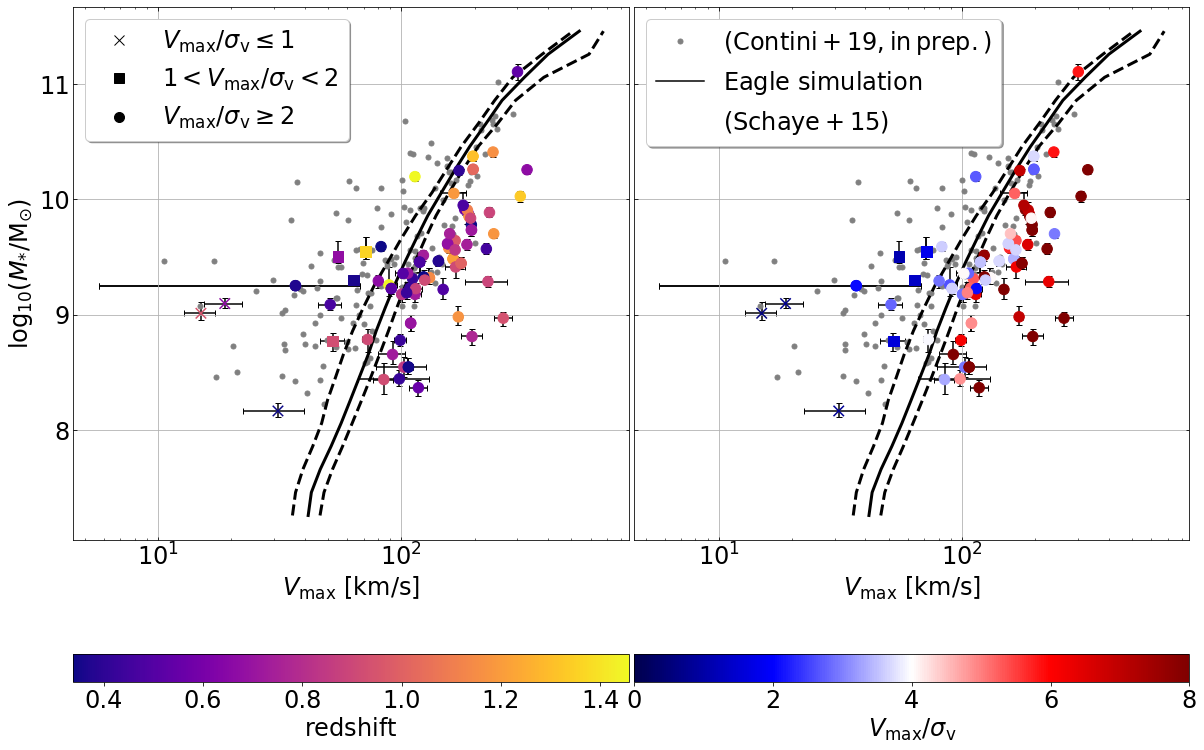

In [174]:
plt.rcParams["figure.figsize"] = (20, 14) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.01, hspace=0.0)

V_sigma  = Vmax/sigma
pos1     = V_sigma <= 1
pos2     = np.logical_and(V_sigma < 2, V_sigma>1)
pos3     = V_sigma >= 2

size1    = np.copy(V_sigma[pos1])*0+110
size2    = np.copy(V_sigma[pos2])*0+110
size3    = np.copy(V_sigma[pos1])*0+110


ax, tmp = asManyPlots(121,
            [Vmax[pos1], Vmax[pos2], Vmax[pos3], eagle, eagleLE, eagleUE, VmaxCONTINI], 
            [lmass[pos1], lmass[pos2], lmass[pos3], eaglelogM, eaglelogM, eaglelogM, lmassCONTINI], 
            xlabel=r"$V_{\rm{max}} \,\, [\rm{km/s]}$",
            ylabel=r"$\log_{10} (M_{*} / \rm{M_{\odot}})$",
            plotFlag=[False, False, False, True, True, True, True],
            zorder=[12, 11, 10, 9, 9, 9, 8],
            color=[red[pos1], red[pos2], red[pos3], 'black', 'black', 'black', 'grey'],
            marker=['x', 's', 'o', 'None', 'None', 'None', '.'],
            markerSize=[size1, size2, size3, 16, 16, 16, 10],
            unfilledFlag=[False, False, False, False, False, False, False],
            linestyle=[None, None, None, "-", "--", "--", 'None'],
            cmap='plasma', 
            cmapMax=np.max(red),
            showColorbar=True,
            colorbarLabel=r'$\rm{redshift}$',
            colorbarOrientation='horizontal'
            )
#Adding error bars on top
plt.errorbar(Vmax, lmass, xerr=dVmax, yerr=[lmass-lmassLE, lmassUE-lmass], color='k', linestyle='None', zorder=0, capsize=3)

plt.xscale('log')
lowest  = mlines.Line2D([], [], color='black', marker='x', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}}  \leq 1$', linestyle='None')
low     = mlines.Line2D([], [], color='black', marker='s', markersize=10, label=r'$1 < V_{\rm{max}}/\sigma_{\rm{v}} < 2$', linestyle='None')
high    = mlines.Line2D([], [], color='black', marker='o', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}} \geq 2$', linestyle='None')
plt.legend(handles=[lowest, low, high], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)


ax, tmp = asManyPlots(122,
            [Vmax[pos1], Vmax[pos2], Vmax[pos3], eagle, eagleLE, eagleUE, VmaxCONTINI], 
            [lmass[pos1], lmass[pos2], lmass[pos3], eaglelogM, eaglelogM, eaglelogM, lmassCONTINI], 
            xlabel=r"$V_{\rm{max}} \,\, [\rm{km/s]}$",
            ylabel=r"$\log_{10} (M_{*} / \rm{M_{\odot}})$",
            hideYlabel=True,
            hideYticks=True,     
            plotFlag=[False, False, False, True, True, True, True],
            zorder=[12, 11, 10, 9, 9, 9, 8],
            color=[V_sigma[pos1], V_sigma[pos2], V_sigma[pos3], 'black', 'black', 'black', 'grey'],
            marker=['x', 's', 'o', 'None', 'None', 'None', '.'],
            markerSize=[size1, size2, size3, 16, 16, 16, 10],
            unfilledFlag=[False, False, False, False, False, False, False],
            linestyle=[None, None, None, "-", "--", "--", 'None'],
            cmap='seismic', 
            showColorbar=True,
            cmapMax=8,
            cmapMin=0,
            colorbarLabel=r'$V_{\rm{max}} / \sigma_{\rm{v}}$',
            colorbarOrientation='horizontal',
            )
#Adding error bars on top
plt.errorbar(Vmax, lmass, xerr=dVmax, yerr=[lmass-lmassLE, lmassUE-lmass], color='k', linestyle='None', zorder=0, capsize=3)

plt.xscale('log')


eag1    = mlines.Line2D([], [], color='black', marker='None', markersize=10, label=r'$\rm{Eagle \,\, simulation}$', linestyle='-')
eag2    = mlines.Line2D([], [], color='black', marker='None', markersize=10, label=r'$\rm{(Schaye+15)}$', linestyle='None')
CONT    = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', markersize=10, label=r'$\rm{(Contini+19, in \, prep.)}$')
plt.legend(handles=[CONT, eag1, eag2], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)


plt.savefig("Plots/TFRz.pdf", bbox_inches='tight')

# Keeping galaxies with correct inclination

False
False
False
True
False


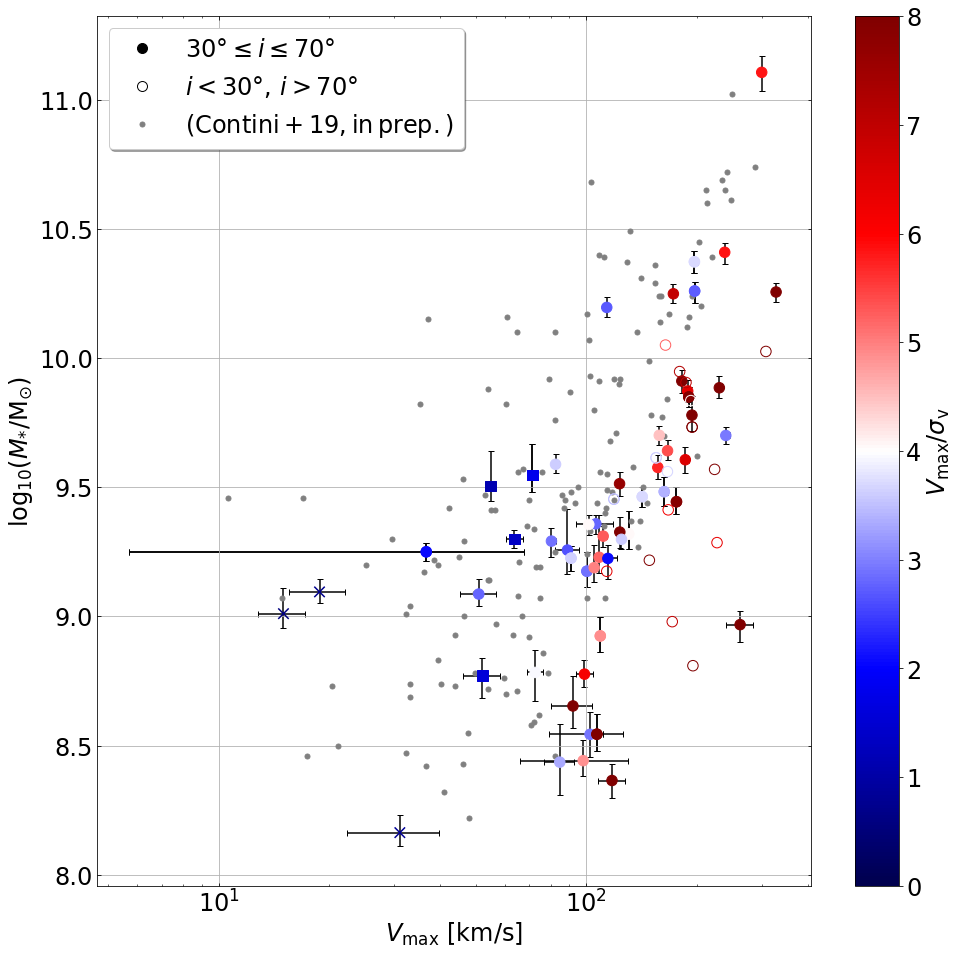

In [27]:
plt.rcParams["figure.figsize"] = (16, 16) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.01, hspace=0.0)

V_sigma  = Vmax/sigma

pos      = np.logical_and(i<=70, i>=30)
poss     = np.logical_not(pos)

pos1     = V_sigma[pos] <= 1
pos2     = np.logical_and(V_sigma[pos] < 2, V_sigma[pos]>1)
pos3     = V_sigma[pos] >= 2

size1    = np.copy(V_sigma[pos][pos1])*0+110
size2    = np.copy(V_sigma[pos][pos2])*0+110
size3    = np.copy(V_sigma[pos][pos1])*0+110
size4    = np.copy(V_sigma[poss])*0+110

ax, tmp = asManyPlots(111,
            [Vmax[pos][pos1], Vmax[pos][pos2], Vmax[pos][pos3], VmaxCONTINI, Vmax[poss]], 
            [lmass[pos][pos1], lmass[pos][pos2], lmass[pos][pos3], lmassCONTINI, lmass[poss]], 
            xlabel=r"$V_{\rm{max}} \,\, [\rm{km/s]}$",
            ylabel=r"$\log_{10} (M_{*} / \rm{M_{\odot}})$",  
            plotFlag=[False, False, False, True, False],
            zorder=[12, 11, 10, 9, 13],
            color=[V_sigma[pos][pos1], V_sigma[pos][pos2], V_sigma[pos][pos3], 'grey', V_sigma[poss]],
            marker=['x', 's', 'o', '.', 'o'],
            markerSize=[size1, size2, size3, 10, size4],
            unfilledFlag=[False, False, False, False, True],
            linestyle=[None, None, None, 'None', None],
            cmap='seismic', 
            showColorbar=True,
            cmapMax=8,
            cmapMin=0,
            colorbarLabel=r'$V_{\rm{max}} / \sigma_{\rm{v}}$',
            colorbarOrientation='vertical',
            )
#Adding error bars on top
plt.errorbar(Vmax[pos], lmass[pos], xerr=(dVmax)[pos], yerr=[(lmass-lmassLE)[pos], (lmassUE-lmass)[pos]], color='k', linestyle='None', zorder=0, capsize=3)

plt.xscale('log')

inc    = mlines.Line2D([], [], color='black', marker='o', markersize=10, label=r'$30\degree \leq i \leq 70\degree$', linestyle='none')
noninc = mlines.Line2D([], [], color='black', marker='o', fillstyle='none', markersize=10, label=r'$i < 30\degree , \, i > 70\degree$', linestyle='none')
CONT    = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', markersize=10, label=r'$\rm{(Contini+19, in \, prep.)}$')
plt.legend(handles=[inc, noninc, CONT], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)

plt.savefig("Plots/TFR_vel_corrected_of_i.pdf", bbox_inches='tight')

In [32]:
print(len(Vmax[poss][V_sigma[poss]>4]))
for mm, vm, vsig, ii in zip(lmass[poss], Vmax[poss], V_sigma[poss], i[poss]):
    if vsig>4:
        print(mm, vm, vsig, ii)

14
9.17468 113.7 6.423728813559323 70.79190919299037
10.0252 308.2 14.817307692307692 76.29045469189148
10.05 164.3 5.2324840764331215 24.076721644604394
9.28552 226.9 6.355742296918767 19.779822812305838
9.90513 186.8 7.022556390977444 73.50091694471527
9.41239 167.1 6.211895910780669 21.092603534956734
9.21741 148.5 10.45774647887324 76.29045469189148
9.56897 223.5 8.010752688172044 72.48232466475378
9.94734 179.5 7.208835341365463 70.60978761394773
9.73273 194.1 9.608910891089108 70.12312592992117
9.73273 194.1 9.608910891089108 70.12312592992117
8.97976 171.4 6.967479674796748 72.90241731273376
9.83516 192.5 4.087048832271762 71.63918620607414
8.80934 195.1 9.379807692307692 29.308109235525464


# Looking for a correlation between SFR and $V/\sigma$

False
False
False
[ 1.96554246  1.97753395  3.75529945 18.22249996 15.36379423  2.29078994
  0.03861272  2.39625782  1.36945729  0.70108449  2.97357831  4.40236375
  0.50449144  2.82647547  1.12861601  2.05812498  6.52657185 12.52460392
 13.50870838  1.12634956 15.40309728  2.79131459  1.04753519  6.94884524
  5.12664613  4.68357496  5.86005835  5.69816313  3.91678972  4.00196555
  1.50900292 10.30747515  2.25371237  6.94884524  5.12664613  4.68357496
  5.86005835  5.69816313  3.91678972  4.00196555  1.50900292 10.30747515
  2.25371237  1.88439257  2.15135155  5.78396369  0.67737764  1.73467761
  0.64160592  6.00699347  6.13772935  1.71881801  1.45518933  1.04827696
  3.34871352  0.63836525  1.40713063  7.06041283 12.90494997  1.04827696
  3.34871352  0.63836525  1.40713063  7.06041283 12.90494997  9.60978887
  2.29539372  0.58596006  1.75634554 17.54123765  3.09258145  2.09710817
  3.43668458  3.87353088  7.57872856  4.68446584  2.15568022  1.30189619
  1.27757656  5.67835401  1.78684

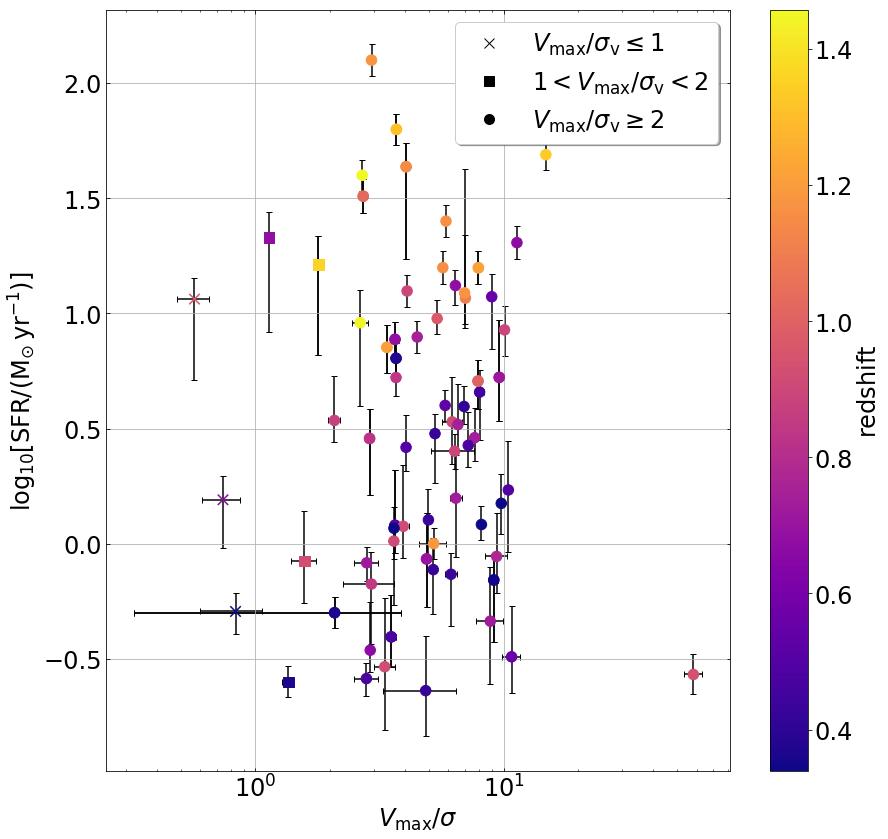

In [115]:
plt.rcParams["figure.figsize"] = (14, 14) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.01, hspace=0.0)

V_sigma  = Vmax/sigma

pos1     = V_sigma <= 1
pos2     = np.logical_and(V_sigma < 2, V_sigma>1)
pos3     = V_sigma >= 2

size1    = np.copy(V_sigma[pos1])*0+110
size2    = np.copy(V_sigma[pos2])*0+110
size3    = np.copy(V_sigma[pos1])*0+110

Vtot     = np.sqrt(Vmax**2 + sigma**2) 

ax, tmp   = asManyPlots(111,
            [V_sigma[pos1], V_sigma[pos2], V_sigma[pos3]], 
            [lsfr[pos1], lsfr[pos2], lsfr[pos3]], 
            xlabel=r"$V_{\rm{max}} / \sigma}$",
            ylabel=r"$\log_{10} [\rm{SFR / ( M_{\odot} \, yr^{-1})}]$",
            plotFlag=[False, False, False],
            zorder=[12, 11, 10, 9, 9, 9],
            color=[red[pos1], red[pos2], red[pos3]],
            marker=['x', 's', 'o'],
            markerSize=[size1, size2, size3],
            unfilledFlag=[False, False, False],
            linestyle=[None, None, None],
            cmap='plasma', 
            cmapMax=np.max(red),
            showColorbar=True,
            colorbarLabel=r'$\rm{redshift}$',
            colorbarOrientation='vertical'
            )
#Adding error bars on top
plt.errorbar(V_sigma, lsfr, xerr=dVmax/sigma, yerr=[lsfr-lsfrLE, lsfrUE-lsfr], color='k', linestyle='None', zorder=0, capsize=3)

plt.xscale('log')
lowest  = mlines.Line2D([], [], color='black', marker='x', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}}  \leq 1$', linestyle='None')
low     = mlines.Line2D([], [], color='black', marker='s', markersize=10, label=r'$1 < V_{\rm{max}}/\sigma_{\rm{v}} < 2$', linestyle='None')
high    = mlines.Line2D([], [], color='black', marker='o', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}} \geq 2$', linestyle='None')
plt.legend(handles=[lowest, low, high], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)


plt.savefig("Plots/SFR_V_sigma.pdf", bbox_inches='tight')

print(Vtot-Vmax)

# Looking for a correlation between SFR and $\sigma$

False
False
False
[ 1.96554246  1.97753395  3.75529945 18.22249996 15.36379423  2.29078994
  0.03861272  2.39625782  1.36945729  0.70108449  2.97357831  4.40236375
  0.50449144  2.82647547  1.12861601  2.05812498  6.52657185 12.52460392
 13.50870838  1.12634956 15.40309728  2.79131459  1.04753519  6.94884524
  5.12664613  4.68357496  5.86005835  5.69816313  3.91678972  4.00196555
  1.50900292 10.30747515  2.25371237  6.94884524  5.12664613  4.68357496
  5.86005835  5.69816313  3.91678972  4.00196555  1.50900292 10.30747515
  2.25371237  1.88439257  2.15135155  5.78396369  0.67737764  1.73467761
  0.64160592  6.00699347  6.13772935  1.71881801  1.45518933  1.04827696
  3.34871352  0.63836525  1.40713063  7.06041283 12.90494997  1.04827696
  3.34871352  0.63836525  1.40713063  7.06041283 12.90494997  9.60978887
  2.29539372  0.58596006  1.75634554 17.54123765  3.09258145  2.09710817
  3.43668458  3.87353088  7.57872856  4.68446584  2.15568022  1.30189619
  1.27757656  5.67835401  1.78684

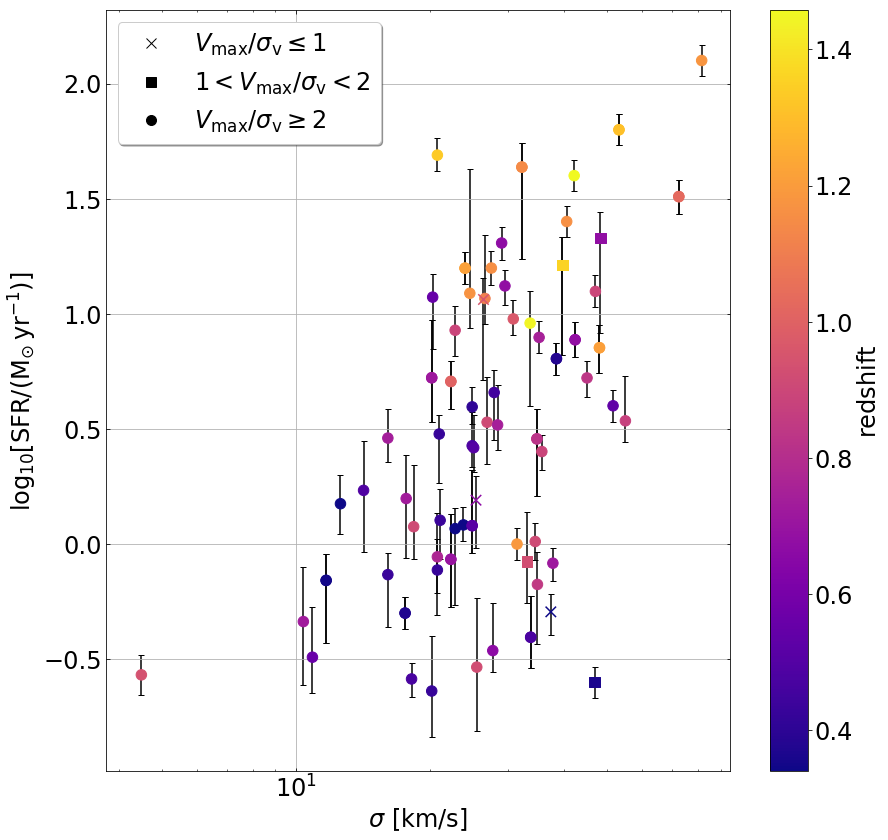

In [123]:
plt.rcParams["figure.figsize"] = (14, 14) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.01, hspace=0.0)

V_sigma  = Vmax/sigma

pos1     = V_sigma <= 1
pos2     = np.logical_and(V_sigma < 2, V_sigma>1)
pos3     = V_sigma >= 2

size1    = np.copy(V_sigma[pos1])*0+110
size2    = np.copy(V_sigma[pos2])*0+110
size3    = np.copy(V_sigma[pos1])*0+110

Vtot     = np.sqrt(Vmax**2 + sigma**2) 

ax, tmp   = asManyPlots(111,
            [sigma[pos1], sigma[pos2], sigma[pos3]], 
            [lsfr[pos1], lsfr[pos2], lsfr[pos3]], 
            xlabel=r"$\sigma \,\, [\rm{km/s}]$",
            ylabel=r"$\log_{10} [\rm{SFR / ( M_{\odot} \, yr^{-1})}]$",
            plotFlag=[False, False, False],
            zorder=[12, 11, 10, 9, 9, 9],
            color=[red[pos1], red[pos2], red[pos3]],
            marker=['x', 's', 'o'],
            markerSize=[size1, size2, size3],
            unfilledFlag=[False, False, False],
            linestyle=[None, None, None],
            cmap='plasma', 
            cmapMax=np.max(red),
            showColorbar=True,
            colorbarLabel=r'$\rm{redshift}$',
            colorbarOrientation='vertical'
            )
#Adding error bars on top
plt.errorbar(sigma, lsfr, yerr=[lsfr-lsfrLE, lsfrUE-lsfr], color='k', linestyle='None', zorder=0, capsize=3)

plt.xscale('log')
lowest  = mlines.Line2D([], [], color='black', marker='x', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}}  \leq 1$', linestyle='None')
low     = mlines.Line2D([], [], color='black', marker='s', markersize=10, label=r'$1 < V_{\rm{max}}/\sigma_{\rm{v}} < 2$', linestyle='None')
high    = mlines.Line2D([], [], color='black', marker='o', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}} \geq 2$', linestyle='None')
plt.legend(handles=[lowest, low, high], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)


plt.savefig("Plots/SFR_sigma.pdf", bbox_inches='tight')

print(Vtot-Vmax)

# Looking for a correlation between SFR and $V_{\rm{max}}$

False
False
False
[ 1.96554246  1.97753395  3.75529945 18.22249996 15.36379423  2.29078994
  0.03861272  2.39625782  1.36945729  0.70108449  2.97357831  4.40236375
  0.50449144  2.82647547  1.12861601  2.05812498  6.52657185 12.52460392
 13.50870838  1.12634956 15.40309728  2.79131459  1.04753519  6.94884524
  5.12664613  4.68357496  5.86005835  5.69816313  3.91678972  4.00196555
  1.50900292 10.30747515  2.25371237  6.94884524  5.12664613  4.68357496
  5.86005835  5.69816313  3.91678972  4.00196555  1.50900292 10.30747515
  2.25371237  1.88439257  2.15135155  5.78396369  0.67737764  1.73467761
  0.64160592  6.00699347  6.13772935  1.71881801  1.45518933  1.04827696
  3.34871352  0.63836525  1.40713063  7.06041283 12.90494997  1.04827696
  3.34871352  0.63836525  1.40713063  7.06041283 12.90494997  9.60978887
  2.29539372  0.58596006  1.75634554 17.54123765  3.09258145  2.09710817
  3.43668458  3.87353088  7.57872856  4.68446584  2.15568022  1.30189619
  1.27757656  5.67835401  1.78684

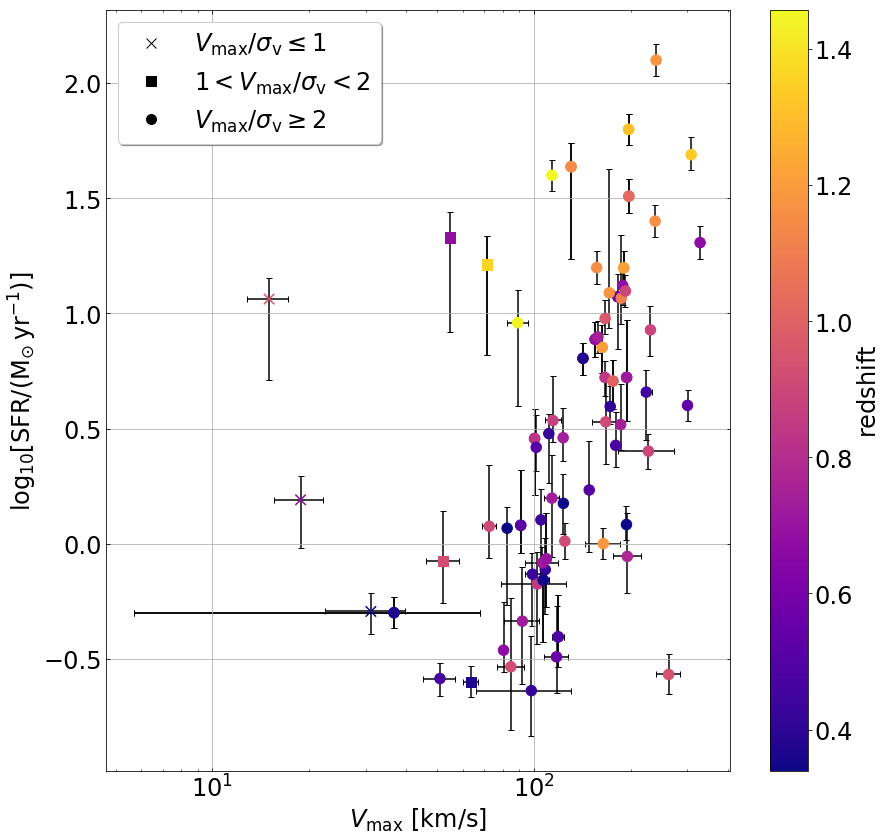

In [122]:
plt.rcParams["figure.figsize"] = (14, 14) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.01, hspace=0.0)

V_sigma  = Vmax/sigma

pos1     = V_sigma <= 1
pos2     = np.logical_and(V_sigma < 2, V_sigma>1)
pos3     = V_sigma >= 2

size1    = np.copy(V_sigma[pos1])*0+110
size2    = np.copy(V_sigma[pos2])*0+110
size3    = np.copy(V_sigma[pos1])*0+110

Vtot     = np.sqrt(Vmax**2 + sigma**2) 

ax, tmp   = asManyPlots(111,
            [Vmax[pos1], Vmax[pos2], Vmax[pos3]], 
            [lsfr[pos1], lsfr[pos2], lsfr[pos3]], 
            xlabel=r"$V_{\rm{max}} \,\, [\rm{km/s}]$",
            ylabel=r"$\log_{10} [\rm{SFR / ( M_{\odot} \, yr^{-1})}]$",
            plotFlag=[False, False, False],
            zorder=[12, 11, 10, 9, 9, 9],
            color=[red[pos1], red[pos2], red[pos3]],
            marker=['x', 's', 'o'],
            markerSize=[size1, size2, size3],
            unfilledFlag=[False, False, False],
            linestyle=[None, None, None],
            cmap='plasma', 
            cmapMax=np.max(red),
            showColorbar=True,
            colorbarLabel=r'$\rm{redshift}$',
            colorbarOrientation='vertical'
            )
#Adding error bars on top
plt.errorbar(Vmax, lsfr,xerr=dVmax, yerr=[lsfr-lsfrLE, lsfrUE-lsfr], color='k', linestyle='None', zorder=0, capsize=3)

plt.xscale('log')
lowest  = mlines.Line2D([], [], color='black', marker='x', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}}  \leq 1$', linestyle='None')
low     = mlines.Line2D([], [], color='black', marker='s', markersize=10, label=r'$1 < V_{\rm{max}}/\sigma_{\rm{v}} < 2$', linestyle='None')
high    = mlines.Line2D([], [], color='black', marker='o', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}} \geq 2$', linestyle='None')
plt.legend(handles=[lowest, low, high], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)


plt.savefig("Plots/SFR_Vmax.pdf", bbox_inches='tight')

print(Vtot-Vmax)

# Log(M) = f(Vmax) as a function of size in kpc

## computing comoving transverse distance

In [52]:
from cosmolopy.distance import angular_diameter_distance
cosmo = {'omega_M_0' : 0.3, 'omega_lambda_0' : 0.7, 'omega_k_0' : 0.0, 'h' : 0.72}

#*1e3 because size is given in Mcp and we want it in kpc
size_kpc = angular_diameter_distance(red, **cosmo)*R1_2/3600*np.pi/180*1e3

In [53]:
size_kpc

array([26.76699311, 26.8756046 , 13.56591856, 12.40853885, 19.73983721,
       21.55512729, 15.64315641, 28.13028395, 17.17128111, 34.01028452,
       19.27372145, 29.12215373, 31.04317445, 26.64503593, 19.48041159,
       19.31896899, 30.42399144, 23.23259492, 22.10993864, 18.86109059,
       11.19864805, 14.42048348, 13.63723773, 19.34050756, 28.42152924,
       20.32620233, 25.28411564, 33.73488023, 23.68905052, 27.28116857,
       25.3427343 , 22.8688194 , 16.62053485, 19.34050756, 28.42152924,
       20.32620233, 25.28411564, 33.73488023, 23.68905052, 27.28116857,
       25.3427343 , 22.8688194 , 16.62053485, 25.24809185, 14.57488428,
       15.75921895, 27.35297219, 22.38952487, 23.46418753, 16.30365327,
       15.80446273, 14.78281807, 16.80779777, 24.804367  , 19.56981517,
       11.05242931, 23.76676079, 20.42999669, 22.99566008, 24.804367  ,
       19.56981517, 11.05242931, 23.76676079, 20.42999669, 22.99566008,
       15.28130244, 16.35339418, 14.84566536, 19.55065502, 11.42

False
False
False
True


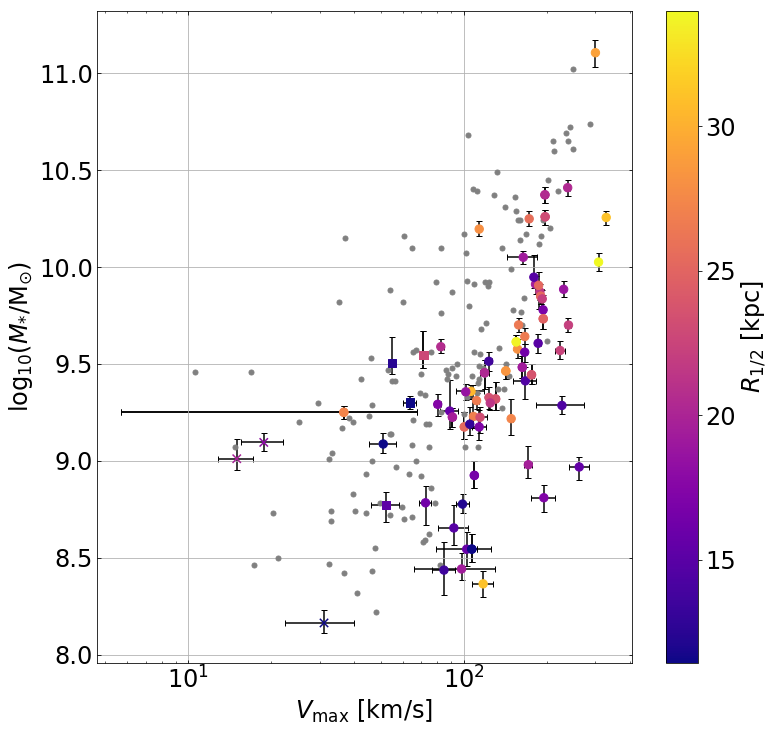

In [63]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.0)

V_sigma  = Vmax/sigma
pos1     = V_sigma <= 1
pos2     = np.logical_and(V_sigma < 2, V_sigma>1)
pos3     = V_sigma >= 2

size1    = np.copy(V_sigma[pos1])*0+70
size2    = np.copy(V_sigma[pos2])*0+70
size3    = np.copy(V_sigma[pos1])*0+70

#Adding error bars on top
plt.errorbar(Vmax, lmass, xerr=dVmax, yerr=[lmass-lmassLE, lmassUE-lmass], color='k', linestyle='None', zorder=0, capsize=3)

ax, tmp = asManyPlots(111,
            [Vmax[pos1], Vmax[pos2], Vmax[pos3], VmaxCONTINI], 
            [lmass[pos1], lmass[pos2], lmass[pos3], lmassCONTINI], 
            xlabel=r"$V_{\rm{max}} \,\, [\rm{km/s]}$",
            ylabel=r"$\log_{10} (M_{*} / \rm{M_{\odot}})$",
            plotFlag=[False, False, False, True],
            zorder=[12, 11, 10, 8],
            color=[size_kpc[pos1], size_kpc[pos2], size_kpc[pos3], 'grey'],
            marker=['x', 's', 'o', '.'],
            markerSize=[size1, size2, size3, 10],
            unfilledFlag=[False, False, False, False],
            linestyle=[None, None, None, 'None'],
            cmap='plasma', 
            cmapMax=np.max(size_kpc),
            showColorbar=True,
            colorbarLabel=r'$R_{1/2} \,\, [\rm{kpc}]$'
            )
plt.xscale('log')

lowest  = mlines.Line2D([], [], color='black', marker='x', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}}  \leq 1$', linestyle='None')
low     = mlines.Line2D([], [], color='black', marker='s', markersize=10, label=r'$1 < V_{\rm{max}}/\sigma_{\rm{v}} < 2$', linestyle='None')
high    = mlines.Line2D([], [], color='black', marker='o', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}} \geq 2$', linestyle='None')
eag1    = mlines.Line2D([], [], color='black', marker='None', markersize=10, label=r'$\rm{Eagle \,\, simulation}$', linestyle='-')
eag2    = mlines.Line2D([], [], color='black', marker='None', markersize=10, label=r'$\rm{(Schaye+15)}$', linestyle='None')
#plt.legend(handles=[lowest, low, high, eag1, eag2], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)

plt.savefig("Plots/TFR_sizeKPC.pdf", bbox_inches='tight')

# Binning to see an evolution

False
False
False


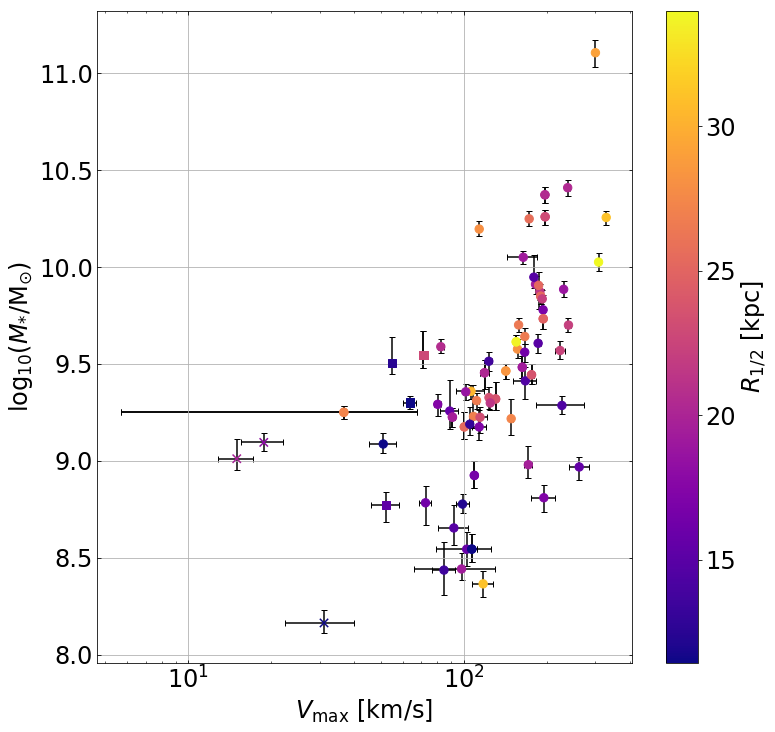

In [61]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.0)

V_sigma  = Vmax/sigma
pos1     = V_sigma <= 1
pos2     = np.logical_and(V_sigma < 2, V_sigma>1)
pos3     = V_sigma >= 2

size1    = np.copy(V_sigma[pos1])*0+70
size2    = np.copy(V_sigma[pos2])*0+70
size3    = np.copy(V_sigma[pos1])*0+70



#Adding error bars on top
plt.errorbar(Vmax, lmass, xerr=dVmax, yerr=[lmass-lmassLE, lmassUE-lmass], color='k', linestyle='None', zorder=0, capsize=3)

ax, tmp = asManyPlots(111,
            [Vmax[pos1], Vmax[pos2], Vmax[pos3]], 
            [lmass[pos1], lmass[pos2], lmass[pos3]], 
            xlabel=r"$V_{\rm{max}} \,\, [\rm{km/s]}$",
            ylabel=r"$\log_{10} (M_{*} / \rm{M_{\odot}})$",
            plotFlag=[False, False, False],
            zorder=[12, 11, 10],
            color=[size_kpc[pos1], size_kpc[pos2], size_kpc[pos3]],
            marker=['x', 's', 'o'],
            markerSize=[size1, size2, size3],
            unfilledFlag=[False, False, False],
            linestyle=[None, None, None],
            cmap='plasma', 
            cmapMax=np.max(size_kpc),
            showColorbar=True,
            colorbarLabel=r'$R_{1/2} \,\, [\rm{kpc}]$'
            )
plt.xscale('log')

lowest  = mlines.Line2D([], [], color='black', marker='x', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}}  \leq 1$', linestyle='None')
low     = mlines.Line2D([], [], color='black', marker='s', markersize=10, label=r'$1 < V_{\rm{max}}/\sigma_{\rm{v}} < 2$', linestyle='None')
high    = mlines.Line2D([], [], color='black', marker='o', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}} \geq 2$', linestyle='None')
eag1    = mlines.Line2D([], [], color='black', marker='None', markersize=10, label=r'$\rm{Eagle \,\, simulation}$', linestyle='-')
eag2    = mlines.Line2D([], [], color='black', marker='None', markersize=10, label=r'$\rm{(Schaye+15)}$', linestyle='None')
#plt.legend(handles=[lowest, low, high, eag1, eag2], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)

plt.savefig("Plots/TFR_sizeKPCBinned.pdf", bbox_inches='tight')

# Log(M) = f(Vmax) as a function of size in px

False
False
False
True
True
True
True


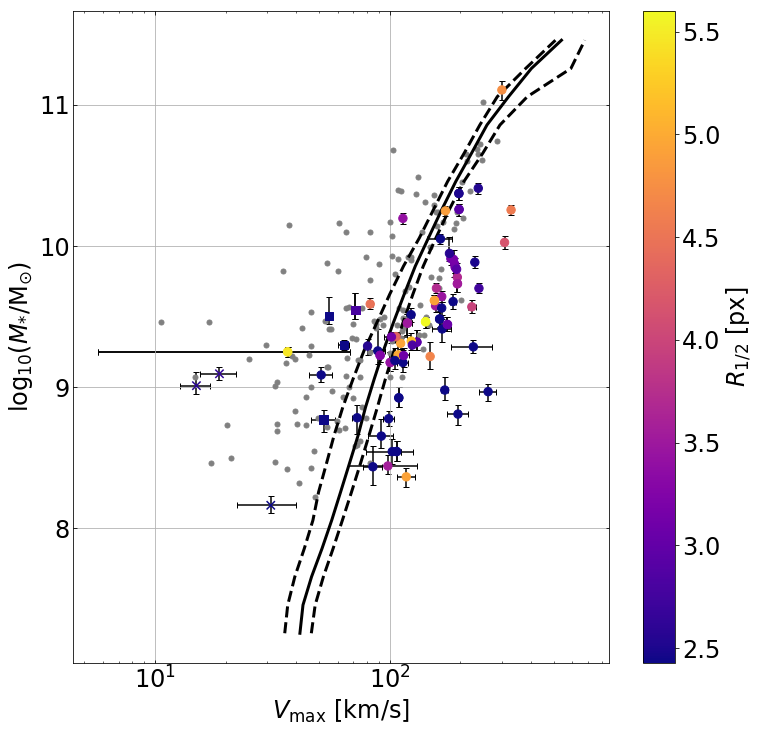

In [60]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.0)

V_sigma  = Vmax/sigma
pos1     = V_sigma <= 1
pos2     = np.logical_and(V_sigma < 2, V_sigma>1)
pos3     = V_sigma >= 2

size1    = np.copy(V_sigma[pos1])*0+70
size2    = np.copy(V_sigma[pos2])*0+70
size3    = np.copy(V_sigma[pos1])*0+70

#Adding error bars on top
plt.errorbar(Vmax, lmass, xerr=dVmax, yerr=[lmass-lmassLE, lmassUE-lmass], color='k', linestyle='None', zorder=0, capsize=3)

ax, tmp = asManyPlots(111,
            [Vmax[pos1], Vmax[pos2], Vmax[pos3], VmaxCONTINI], 
            [lmass[pos1], lmass[pos2], lmass[pos3], eaglelogM, eaglelogM, eaglelogM, lmassCONTINI], 
            xlabel=r"$V_{\rm{max}} \,\, [\rm{km/s]}$",
            ylabel=r"$\log_{10} (M_{*} / \rm{M_{\odot}})$",
            plotFlag=[False, False, False, True, True, True, True],
            zorder=[12, 11, 10, 9, 9, 9, 8],
            color=[R1_2[pos1], R1_2[pos2], R1_2[pos3], 'black', 'black', 'black', 'grey'],
            marker=['x', 's', 'o', 'None', 'None', 'None', '.'],
            markerSize=[size1, size2, size3, 16, 16, 16, 10],
            unfilledFlag=[False, False, False, False, False, False, False],
            linestyle=[None, None, None, "-", "--", "--", 'None'],
            cmap='plasma', 
            cmapMax=np.max(R1_2),
            showColorbar=True,
            colorbarLabel=r'$R_{1/2} \,\, [\rm{px}]$'
            )
plt.xscale('log')

lowest  = mlines.Line2D([], [], color='black', marker='x', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}}  \leq 1$', linestyle='None')
low     = mlines.Line2D([], [], color='black', marker='s', markersize=10, label=r'$1 < V_{\rm{max}}/\sigma_{\rm{v}} < 2$', linestyle='None')
high    = mlines.Line2D([], [], color='black', marker='o', markersize=10, label=r'$V_{\rm{max}}/\sigma_{\rm{v}} \geq 2$', linestyle='None')
eag1    = mlines.Line2D([], [], color='black', marker='None', markersize=10, label=r'$\rm{Eagle \,\, simulation}$', linestyle='-')
eag2    = mlines.Line2D([], [], color='black', marker='None', markersize=10, label=r'$\rm{(Schaye+15)}$', linestyle='None')
#plt.legend(handles=[lowest, low, high, eag1, eag2], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)

plt.savefig("Plots/TFR_sizePX.pdf", bbox_inches='tight')

### Plotting $V_{\rm{max}} / \sigma$ distribution as a function of redshift

False
4.81875
10.45
1.0
0.9069767441860465


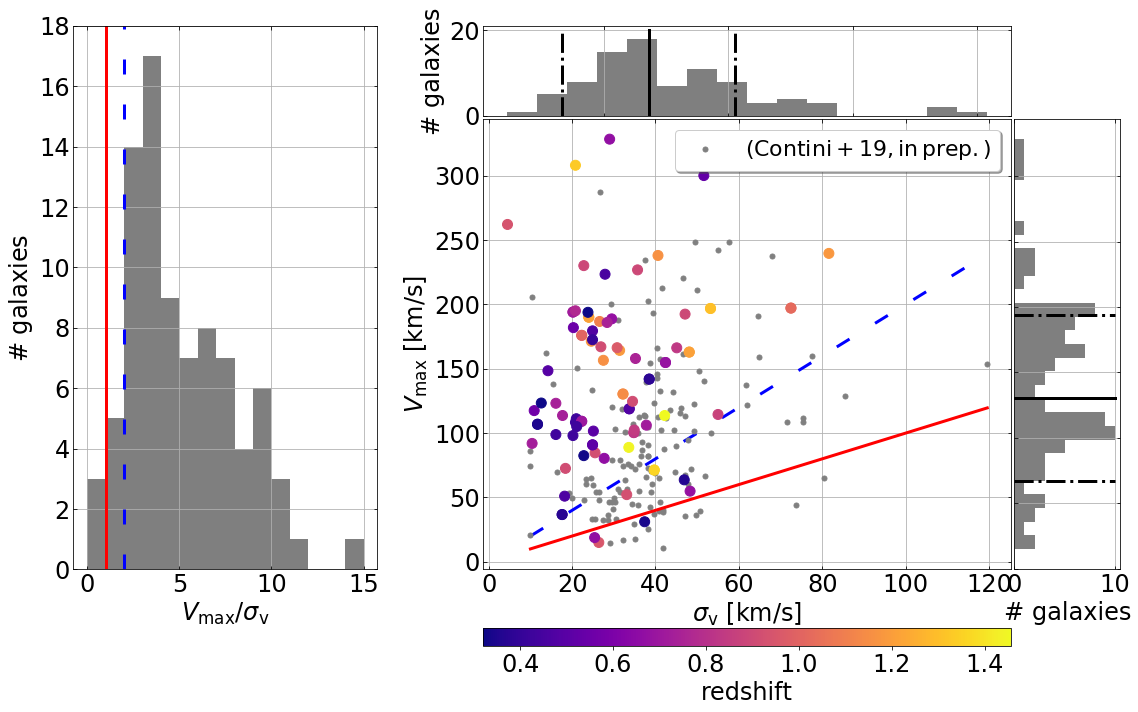

In [105]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec



#linestyles = OrderedDict(
#    [('solid',                (0, ())),
#     ('loosely dashed',       (0, (5, 10))),
#     ('dotted',               (0, (1, 8))),
#     ('densely dashed',       (0, (5, 1))),
#    ])

V_sigma  = Vmax/sigma

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.2], height_ratios=[0.2, 1], left=0.46, right=0.98)

plt.rcParams["figure.figsize"] = (17, 10) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.01, hspace=0.01)

#Making a 1-1 line to diferentiate between dispersion dominated and rotationally supported galaxies
xpoints = [np.min(sigmaCONTINI), np.max(sigmaCONTINI)]

ax, ret= asManyPlots(gs[2],
            sigma, Vmax, 
            xlabel=r"$\sigma_{\rm{v}} \,\, [\rm{km/s}]$", ylabel=r"$V_{\rm{max}} \,\, [\rm{km/s}]$",
            plotFlag=[False], 
            color=[red],
            marker=['o'],
            unfilledFlag=[False],
            linestyle=[None],
            cmap='plasma', 
            showColorbar=False, 
            markerSize=100,
            zorder=8,
            colorbarOrientation='horizontal',
            colorbarLabel=r'$\rm{redshift \,\, z}$')
plt.plot(sigmaCONTINI, VmaxCONTINI, marker='.', color='grey', linestyle='None', markersize=10, zorder=7)
plt.plot(xpoints, xpoints, linestyle="-", linewidth=3, color='red', zorder=7)
plt.plot(xpoints, [i*2 for i in xpoints], linestyle=(0, (5, 10)), linewidth=3, color='blue', zorder=6)

CONT    = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', markersize=10, label=r'$\rm{(Contini+19, in \, prep.)}$')
plt.legend(handles=[CONT], loc='best', prop={'size': 22}, shadow=True, fancybox=True).set_zorder(1000)

axins = inset_axes(ax,
           width="100%", # width = 10% of parent_bbox width
           height="3%", # height : 50%
           loc=6,
           bbox_to_anchor=(0, -0.8, 1, 1.3),
           bbox_transform=ax.transAxes,
           borderpad=0,
       )
axins.tick_params(labelsize=24)

col = plt.colorbar(ret, cax=axins, orientation='horizontal')
col.set_label("redshift", size=24)




ax, n, bns, ptchs = asManyHists(gs[0], sigma, bins=16,
                                ylabel="# galaxies",
                                hideXlabel=True, 
                                alpha=0.5)
plt.plot([np.median(sigma), np.median(sigma)], [0, 20], linestyle='-', color='k', linewidth=3)
plt.plot([np.median(sigma)+np.std(sigma), np.median(sigma)+np.std(sigma)], [0, 20], linestyle='-.', color='k', linewidth=3)
plt.plot([np.median(sigma)-np.std(sigma), np.median(sigma)-np.std(sigma)], [0, 20], linestyle='-.', color='k', linewidth=3)
print(bns[1]-bns[0])





ax, n, bns, ptchs = asManyHists(gs[3], Vmax, bins=30,
                                xlabel="# galaxies",
                                hideYlabel=True, 
                                hideYticks=True,
                                alpha=0.5,
                                orientation='horizontal')
plt.plot([0, 10], [np.median(Vmax), np.median(Vmax)], linestyle='-', color='k', linewidth=3)
plt.plot([0, 10], [np.median(Vmax)+np.std(Vmax), np.median(Vmax)+np.std(Vmax)], linestyle='-.', color='k', linewidth=3)
plt.plot([0, 10], [np.median(Vmax)-np.std(Vmax), np.median(Vmax)-np.std(Vmax)], linestyle='-.', color='k', linewidth=3)
print(bns[1]-bns[0])

gs = gridspec.GridSpec(2, 3, width_ratios=[0.28, 0.4, 0.3], height_ratios=[1, 1], right=1)
ax, n, bns, ptchs = asManyHists(gs[:,0], V_sigma, bins=15,
                                histtype="bar",
                                xlabel=r"$V_{{\rm{max}}} / \sigma_{\rm{v}}$",
                                ylabel=r'$\rm{\# \,\, galaxies}$',
                                alpha=0.5,
                                xlim=[0, 15])

ax.set_ylim(top=18)
plt.plot([1, 1], [0, 18], color='red', linewidth=3)
plt.plot([2, 2], [0, 18], color='blue', linestyle=(0, (5, 10)), linewidth=3)

print(bns[1]-bns[0])

V_sigma  = Vmax/sigma
print(len(np.where(V_sigma>2)[0])/len(np.where(V_sigma)[0]))

plt.savefig("Plots/V_sigma.pdf", bbox_inches='tight')

In [159]:
srt           = np.argsort(sigma)
ordered_sigma = sigma[srt]
ordered_red   = red[srt]
pos_red       = np.where(ordered_sigma<37)

In [161]:
ordered_sigma

array([ 4.5, 10.4, 10.9, 11.7, 11.7, 12.6, 14.2, 16.1, 16.1, 17.6, 17.6,
       17.7, 18.2, 18.4, 20.2, 20.2, 20.2, 20.3, 20.8, 20.8, 20.8, 21. ,
       21.1, 22.3, 22.3, 22.3, 22.3, 22.8, 22.8, 23.8, 24. , 24. , 24.6,
       24.9, 24.9, 24.9, 24.9, 25.1, 25.4, 25.5, 26.4, 26.6, 26.9, 27.5,
       27.7, 27.9, 28.4, 29. , 29.5, 30.8, 31.4, 32.2, 32.2, 33.1, 33.6,
       33.7, 33.7, 34.5, 34.8, 34.8, 34.9, 35.2, 35.7, 37.4, 37.8, 38.5,
       38.5, 39.7, 39.7, 40.6, 42.2, 42.4, 42.4, 45.1, 46.9, 47.1, 48.1,
       48.1, 48.3, 51.6, 53.2, 53.2, 55. , 72.5, 72.5, 81.6])

In [160]:
pos_red

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),)

In [162]:
print(np.median(ordered_red[:62]))
print(np.median(ordered_red[62:]))
print(np.std(ordered_red[:62]))
print(np.std(ordered_red[62:]))

0.71709
0.895095
0.28896311965798777
0.3473112713640216


# Plotting $V_{\rm{max}} / \sigma$ distribution as a function of redshift

In [20]:
print(np.median(Vmax), np.median(sigma), np.std(Vmax), np.std(sigma))

130.4 27.2 63.489568489025515 13.92525030287918


In [ ]:
# linestyles = OrderedDict(
#    [('solid',                (0, ())),
#     ('loosely dashed',       (0, (5, 10))),
#     ('dotted',               (0, (1, 8))),
#     ('densely dashed',       (0, (5, 1))),
#    ])

V_sigma  = Vmax/sigma
plt.rcParams["figure.figsize"] = (10, 14) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.01, hspace=0.01)

#Making a 1-1 line to diferentiate between dispersion dominated and rotationally supported galaxies
xpoints = [np.min(sigmaCONTINI), np.max(sigmaCONTINI)]

ax, ret= asManyPlots(111,
            sigma, Vmax, 
            xlabel=r"$\sigma_{\rm{v}} \,\, [\rm{km/s}]$", ylabel=r"$V_{\rm{max}} \,\, [\rm{km/s}]$",
            plotFlag=[False], 
            color=[red],
            marker=['o'],
            unfilledFlag=[False],
            linestyle=[None],
            cmap='plasma', 
            showColorbar=True, 
            markerSize=100,
            zorder=8,
            colorbarOrientation='horizontal',
            colorbarLabel=r'$R_{1/2} \,\, [\rm{px}]$')
plt.plot(sigmaCONTINI, VmaxCONTINI, marker='.', color='grey', linestyle='None', markersize=10, zorder=7)
plt.plot(xpoints, xpoints, linestyle="-", linewidth=3, color='red', zorder=7)
plt.plot(xpoints, [i*2 for i in xpoints], linestyle=(0, (5, 10)), linewidth=3, color='blue', zorder=6)
ax.set_xlim(right=90)

CONT    = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', markersize=10, label=r'$\rm{(Contini+19, in \, prep.)}$')
plt.legend(handles=[CONT], loc='best', prop={'size': 22}, shadow=True, fancybox=True).set_zorder(1000)

plt.savefig("a", bbox_inches='tight')

# Plotting $V_{\rm{max}} / \sigma$ distribution as a function of redshift

False


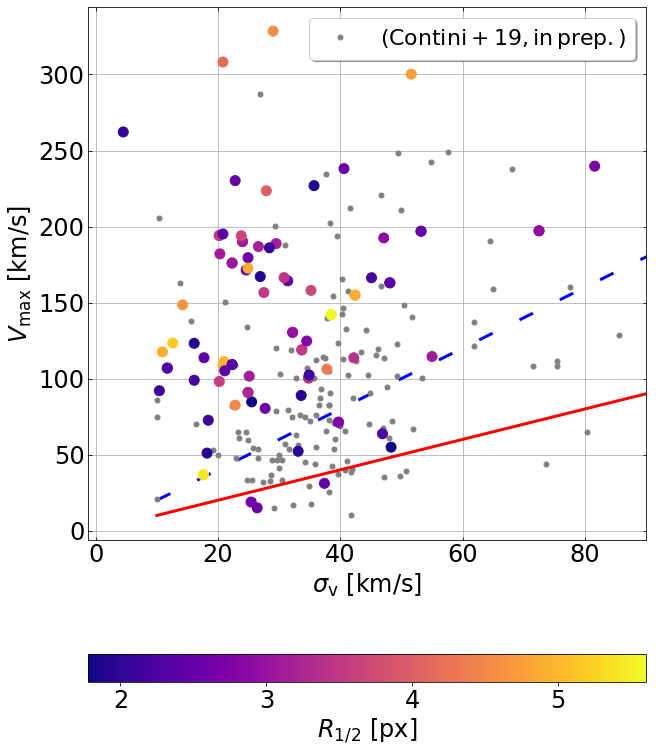

In [18]:
#linestyles = OrderedDict(
#    [('solid',                (0, ())),
#     ('loosely dashed',       (0, (5, 10))),
#     ('dotted',               (0, (1, 8))),
#     ('densely dashed',       (0, (5, 1))),
#    ])

V_sigma  = Vmax/sigma
plt.rcParams["figure.figsize"] = (10, 14) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.01, hspace=0.01)

#Making a 1-1 line to diferentiate between dispersion dominated and rotationally supported galaxies
xpoints = [np.min(sigmaCONTINI), np.max(sigmaCONTINI)]

ax, ret= asManyPlots(111,
            sigma, Vmax, 
            xlabel=r"$\sigma_{\rm{v}} \,\, [\rm{km/s}]$", ylabel=r"$V_{\rm{max}} \,\, [\rm{km/s}]$",
            plotFlag=[False], 
            color=[R1_2],
            marker=['o'],
            unfilledFlag=[False],
            linestyle=[None],
            cmap='plasma', 
            showColorbar=True, 
            markerSize=100,
            zorder=8,
            colorbarOrientation='horizontal',
            colorbarLabel=r'$R_{1/2} \,\, [\rm{px}]$')
plt.plot(sigmaCONTINI, VmaxCONTINI, marker='.', color='grey', linestyle='None', markersize=10, zorder=7)
plt.plot(xpoints, xpoints, linestyle="-", linewidth=3, color='red', zorder=7)
plt.plot(xpoints, [i*2 for i in xpoints], linestyle=(0, (5, 10)), linewidth=3, color='blue', zorder=6)
ax.set_xlim(right=90)

CONT    = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', markersize=10, label=r'$\rm{(Contini+19, in \, prep.)}$')
plt.legend(handles=[CONT], loc='best', prop={'size': 22}, shadow=True, fancybox=True).set_zorder(1000)

plt.savefig("Plots/V_sigma_size.pdf", bbox_inches='tight')